In [45]:
import numpy as np
from os import listdir
from os.path import isfile, join
import tifffile
from cellpose import models, io, core
import time
from sklearn.model_selection import train_test_split
from statistics import mean
from u_net import UNet
import torch
from skimage import measure

In [48]:
def get_files(path,normalise=False,remove_txt=False):
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]

    if remove_txt:
        onlyfiles = [val for val in onlyfiles if not val.endswith(".txt")]

    onlyfiles.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))
    #if num_imgs > len(onlyfiles): num_imgs = len(onlyfiles)
    files = [np.squeeze(tifffile.imread(path +  onlyfiles[i])) for i in range(len(onlyfiles))]
    
    if normalise:
        files = [(image-np.min(image))/(np.max(image)-np.min(image)) for image in files]
    
    return files
    
def get_data(path, set='01',normalise_images=True):

    if len(set) == 2: #set 01 or set 02
        images_path = path + set + '/'
        images = get_files(images_path,normalise=normalise_images)
        masks_path = path + set + '_GT/TRA/'
        masks = get_files(masks_path,remove_txt=True)
    elif set == '0102': #both sets
        images_path = path + '01/'
        images_01 = get_files(images_path,normalise=normalise_images)
        images_path = path + '02/'
        images_02 = get_files(images_path,normalise=normalise_images)
        images = images_01 + images_02

        masks_path = path + '01_GT/TRA/'
        masks_01 = get_files(masks_path,remove_txt=True)
        masks_path = path + '02_GT/TRA/'
        masks_02 = get_files(masks_path,remove_txt=True)
        masks = masks_01 + masks_02
    else:
        images = []
        masks = []

    return images, masks

In [47]:
def get_IoU(predicted_masks,gt_masks):
    intersection_unions = []
    for i in range(len(predicted_masks)):
        intersection = np.logical_and(predicted_masks[i], gt_masks[i]).sum()
        union = np.logical_or(predicted_masks[i], gt_masks[i]).sum()
        intersection_unions.append(intersection/union)
    return mean(intersection_unions)

def get_dice(predicted_masks,gt_masks):
    dices = []
    for i in range(len(predicted_masks)):
        intersection = np.logical_and(predicted_masks[i], gt_masks[i]).sum()
        dice = (2*intersection)/(predicted_masks[i].sum() + gt_masks[i].sum())
        dices.append(dice)
    return mean(dices)

In [49]:
#images_02, masks_02 = get_data("/Users/rehanzuberi/Downloads/distillCellSegTrack/" + 'datasets/Fluo-N2DL-HeLa/', num_imgs=92, set='01')
#images_02, masks_02 = get_data("\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\" + 'datasets/Fluo-N2DL-HeLa/', num_imgs=92, set='01')
images, masks = get_data("\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\" + 'datasets/Fluo-N2DH-GOWT1/', set='0102')

images_train, images_test, masks_train, masks_test = train_test_split(images, masks, test_size=0.2, random_state=42)

In [65]:
#Get cellpose predictions and the distilled U-Net predictions
#cellpose_model = models.CellposeModel(gpu=core.use_gpu(), pretrained_model='/Users/rehanzuberi/Downloads/distillCellSegTrack/segmentation/train_dir/models/cellpose_trained_model')
cellpose_model = models.CellposeModel(gpu=core.use_gpu(), pretrained_model='/Users/rz200/Documents/development/distillCellSegTrack/segmentation/train_dir/models/cellpose_trained_model_GOWT1_2')
print(cellpose_model.diam_labels)
cellpose_predicted_masks = cellpose_model.eval(images_test, batch_size=1, channels=[0,0], diameter=cellpose_model.diam_labels)[0]

45.370316


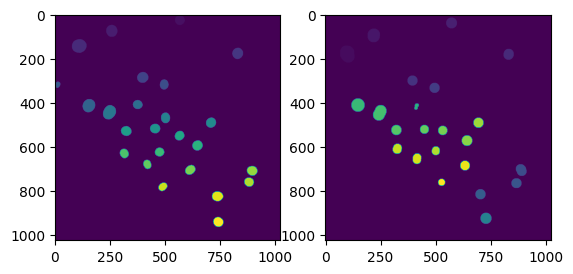

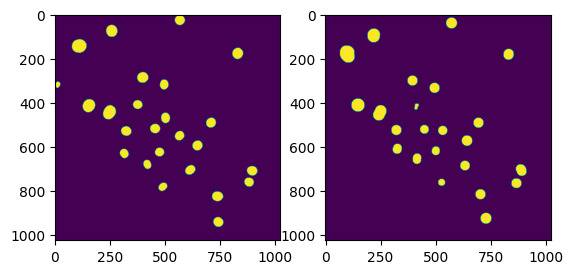

In [64]:
import matplotlib.pyplot as plt

plt.subplot(1,2,1)
plt.imshow(cellpose_predicted_masks[0])
plt.subplot(1,2,2)
plt.imshow(masks_test[0])
plt.show()

bin_pred = np.where(cellpose_predicted_masks[0] > 0, 1, 0)
bin_mask = np.where(masks_test[0] > 0, 1, 0)
plt.subplot(1,2,1)
plt.imshow(bin_pred)
plt.subplot(1,2,2)
plt.imshow(bin_mask)
plt.show()

In [66]:
#Get base cellpose 'cyto' predictions
cellpose_cyto_model = models.Cellpose(gpu=core.use_gpu(),model_type='cyto',device=torch.device('cuda:0'))
cellpose_cyto_predicted_masks = cellpose_cyto_model.eval(images_test, batch_size=1, channels=[0,0])[0]

In [79]:
#Get distilled U-Net predictions
model = UNet()
model = model.to('cuda:0')
#model.load_state_dict(torch.load('/Users/rehanzuberi/Downloads/distillCellSegTrack/segmentation/train_dir/models/unet_trained_model',map_location=torch.device('cpu')))
model.load_state_dict(torch.load('/Users/rz200/Documents/development/distillCellSegTrack/segmentation/train_dir/models/distillation_model_GOWT1_2'))
distilled_predicted_masks = []
for test_image in images_test:
    test_image = torch.from_numpy(test_image).float().unsqueeze(0).unsqueeze(0).to('cuda:0')
    #test_image = torch.from_numpy(test_image).float().unsqueeze(0).unsqueeze(0)
    outputs = model(test_image).squeeze(0).squeeze(0).cpu().detach().numpy()
    outputs = 1/(1+np.exp(-outputs)) #sigmoid the outputs
    binary_outputs = np.where(outputs > 0.5, 1, 0)
    #predicted_instance_mask = measure.label(predicted_binary_mask, connectivity=2)
    distilled_predicted_masks.append(binary_outputs)

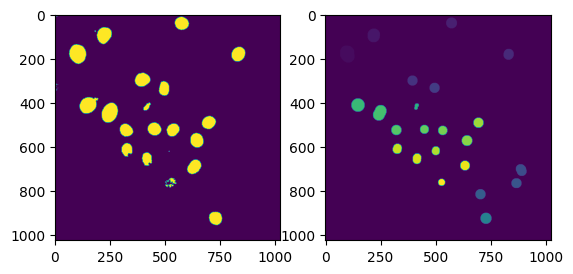

In [81]:
plt.subplot(1,2,1)
plt.imshow(distilled_predicted_masks[0])
plt.subplot(1,2,2)
plt.imshow(masks_test[0])
plt.show()

In [68]:
#Binarise the ground truth masks
masks_02_test_binary = [np.where(mask>0,1,0) for mask in masks_test]

#Binarise the cellpose predictions
cellpose_predicted_masks_binary = [np.where(mask>0,1,0) for mask in cellpose_predicted_masks]
cellpose_cyto_predicted_masks_binary = [np.where(mask>0,1,0) for mask in cellpose_cyto_predicted_masks]

In [82]:
#Get IoU and dice coeff between cellpose trained and groundtruth
print("IoU between cellpose trained and groundtruth: ", get_IoU(cellpose_predicted_masks_binary, masks_02_test_binary))
print("Dice coeff between cellpose trained and groundtruth: ", get_dice(cellpose_predicted_masks_binary, masks_02_test_binary))

#Get IoU and dice coeff between cellpose 'cyto' and groundtruth
print("IoU between cellpose 'cyto' and groundtruth: ", get_IoU(cellpose_cyto_predicted_masks_binary, masks_02_test_binary))
print("Dice coeff between cellpose 'cyto' and groundtruth: ", get_dice(cellpose_cyto_predicted_masks_binary, masks_02_test_binary))

#Get IoU and dice coeff between distilled U-Net and groundtruth
print("IoU between distilled U-Net and groundtruth: ", get_IoU(distilled_predicted_masks, masks_02_test_binary))
print("Dice coeff between distilled U-Net and groundtruth: ", get_dice(distilled_predicted_masks, masks_02_test_binary))

IoU between cellpose trained and groundtruth:  0.7971204504785732
Dice coeff between cellpose trained and groundtruth:  0.8870573172307469
IoU between cellpose 'cyto' and groundtruth:  0.4594282783625755
Dice coeff between cellpose 'cyto' and groundtruth:  0.6277965009528444
IoU between distilled U-Net and groundtruth:  0.5119742938837571
Dice coeff between distilled U-Net and groundtruth:  0.6763417793549859


In [83]:
#Get IoU and dice coeff between cellpose trained and cellpose 'cyto' predictions
print("IoU between cellpose trained and cellpose 'cyto' predictions: ", get_IoU(cellpose_predicted_masks_binary, cellpose_cyto_predicted_masks_binary))
print("Dice coeff between cellpose trained and cellpose 'cyto' predictions: ", get_dice(cellpose_predicted_masks_binary, cellpose_cyto_predicted_masks_binary))

IoU between cellpose trained and cellpose 'cyto' predictions:  0.4430755732605966
Dice coeff between cellpose trained and cellpose 'cyto' predictions:  0.6120528867306952


In [84]:
#These are the distillation results
#Get IoU and dice coeff between distilled U-Net and groundtruth
print("IoU between distilled U-Net and cellpose trained: ", get_IoU(distilled_predicted_masks, cellpose_predicted_masks_binary))
print("Dice coeff between distilled U-Net and cellpose trained: ", get_dice(distilled_predicted_masks, cellpose_predicted_masks_binary))

print("IoU between distilled U-Net and cellpose 'cyto': ", get_IoU(distilled_predicted_masks, cellpose_cyto_predicted_masks_binary))
print("Dice coeff between distilled U-Net and cellpose 'cyto': ", get_dice(distilled_predicted_masks, cellpose_cyto_predicted_masks_binary))

IoU between distilled U-Net and cellpose trained:  0.4899943678285807
Dice coeff between distilled U-Net and cellpose trained:  0.6568543381110395
IoU between distilled U-Net and cellpose 'cyto':  0.823855647321607
Dice coeff between distilled U-Net and cellpose 'cyto':  0.9025351008066373
